In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, f_oneway, kruskal

In [3]:
# Conectar a la base de datos SQLite y extraer la tabla "audio_metadata" (solo los registros procesados)
db_path = "../../db/audio_metadata.db"
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM audio_metadata WHERE processed = TRUE", conn)
conn.close()

# Convertir la columna "datetime" a tipo datetime, si existe
if "datetime" in df.columns:
    df["datetime"] = pd.to_datetime(df["datetime"])

# Lista de índices a evaluar
indices = ["ACI", "ADI", "AEI", "BIO", "NDSI", "H", "AR"]

# Eliminar filas con valores NA en al menos alguno de los índices y en "zone"
df_indices = df.dropna(subset=indices + ["zone"])

# Crear una columna combinada "recorder_zone" para visualizar grabadora y zona juntas
df_indices["recorder_zone"] = df_indices.apply(lambda row: f"{row['recorder']} ({row['zone']})", axis=1)

C:\Users\gonibix23\AppData\Local\Temp\ipykernel_33516\666771091.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_indices["recorder_zone"] = df_indices.apply(lambda row: f"{row['recorder']} ({row['zone']})", axis=1)


In [4]:
alpha = 0.05  # Umbral de significación

print("=== Contrastes de normalidad (Shapiro-Wilk) por grabadora ===")
rec_normality_results = {}

# Obtener las grabadoras únicas
recorders = df_indices["recorder"].unique()

for rec in recorders:
    rec_data = df_indices[df_indices["recorder"] == rec]
    rec_normality_results[rec] = {}
    # Suponemos que la zona es única por grabadora; la extraemos para informar
    zone_info = rec_data["zone"].iloc[0]
    print(f"Grabadora: {rec} (Zona: {zone_info}, n={len(rec_data)})")
    for idx in indices:
        # Para evitar muestras muy grandes, se toma hasta 5000 observaciones
        n_sample = min(5000, len(rec_data))
        if n_sample < 3:
            print(f"  {idx}: Insuficientes datos (n={len(rec_data)})")
            rec_normality_results[rec][idx] = (None, "Insuficiente")
            continue
        sample = rec_data[idx].sample(n=n_sample, random_state=42)
        stat, p_value = shapiro(sample)
        conclusion = "Normal" if p_value > alpha else "No normal"
        rec_normality_results[rec][idx] = (p_value, conclusion)
        print(f"  {idx}: p-value = {p_value:.4f} => {conclusion}")
    print()

=== Contrastes de normalidad (Shapiro-Wilk) por grabadora ===
Grabadora: AM1 (Zona: Matorral, n=22193)
  ACI: p-value = 0.0000 => No normal
  ADI: p-value = 0.0000 => No normal
  AEI: p-value = 0.0000 => No normal
  BIO: p-value = 0.0000 => No normal
  NDSI: p-value = 0.0000 => No normal
  H: p-value = 0.0000 => No normal
  AR: p-value = 0.0000 => No normal

Grabadora: AM10 (Zona: Vera, n=28699)
  ACI: p-value = 0.0000 => No normal
  ADI: p-value = 0.0000 => No normal
  AEI: p-value = 0.0000 => No normal
  BIO: p-value = 0.0000 => No normal
  NDSI: p-value = 0.0000 => No normal
  H: p-value = 0.0000 => No normal
  AR: p-value = 0.0000 => No normal

Grabadora: AM11 (Zona: Vera, n=23812)
  ACI: p-value = 0.0000 => No normal
  ADI: p-value = 0.0000 => No normal
  AEI: p-value = 0.0000 => No normal
  BIO: p-value = 0.0000 => No normal
  NDSI: p-value = 0.0000 => No normal
  H: p-value = 0.0000 => No normal
  AR: p-value = 0.0000 => No normal

Grabadora: AM15 (Zona: Marisma, n=7859)
  ACI: 

In [5]:
print("\n=== Contrastes entre grabadoras para cada índice ===")
rec_results = {}

# Agrupar por grabadora y comparar cada índice entre ellos
df_group = df_indices.dropna(subset=["recorder"])
for idx in indices:
    groups = [group[idx].dropna().values for name, group in df_group.groupby("recorder")]
    if len(groups) < 2:
        print(f"{idx}: No hay suficientes grupos de grabadora para contrastar.")
        continue
    stat_anova, p_anova = f_oneway(*groups)
    stat_kw, p_kw = kruskal(*groups)
    rec_results[idx] = {"ANOVA_p": p_anova, "Kruskal_p": p_kw}

    # Conclusión basada en los p-values
    conclusion = ""
    if p_anova < alpha:
        conclusion += "Las medias difieren significativamente (ANOVA). "
    else:
        conclusion += "No se detecta diferencia significativa en las medias (ANOVA). "
    if p_kw < alpha:
        conclusion += "Las distribuciones difieren significativamente (Kruskal-Wallis)."
    else:
        conclusion += "No se detecta diferencia significativa en las distribuciones (Kruskal-Wallis)."

    print(f"{idx}: ANOVA p-value = {p_anova:.4f}, Kruskal-Wallis p-value = {p_kw:.4f}. Conclusión: {conclusion}")

# Guardar los resultados globales en un archivo CSV
global_results = []
for idx in indices:
    if idx in rec_results:
        global_results.append({
            "Index": idx,
            "ANOVA_p": rec_results[idx]["ANOVA_p"],
            "Kruskal_p": rec_results[idx]["Kruskal_p"],
            "Conclusion": ("Medias difieren (ANOVA)" if rec_results[idx]["ANOVA_p"] < alpha else "Medias no difieren (ANOVA)") + " / " +
                          ("Distribuciones difieren (Kruskal-Wallis)" if rec_results[idx]["Kruskal_p"] < alpha else "Distribuciones no difieren (Kruskal-Wallis)")
        })
    else:
        global_results.append({
            "Index": idx,
            "ANOVA_p": np.nan,
            "Kruskal_p": np.nan,
            "Conclusion": "Insuficientes grupos"
        })


=== Contrastes entre grabadoras para cada índice ===


ACI: ANOVA p-value = 0.0000, Kruskal-Wallis p-value = 0.0000. Conclusión: Las medias difieren significativamente (ANOVA). Las distribuciones difieren significativamente (Kruskal-Wallis).
ADI: ANOVA p-value = 0.0000, Kruskal-Wallis p-value = 0.0000. Conclusión: Las medias difieren significativamente (ANOVA). Las distribuciones difieren significativamente (Kruskal-Wallis).
AEI: ANOVA p-value = 0.0000, Kruskal-Wallis p-value = 0.0000. Conclusión: Las medias difieren significativamente (ANOVA). Las distribuciones difieren significativamente (Kruskal-Wallis).
BIO: ANOVA p-value = 0.0000, Kruskal-Wallis p-value = 0.0000. Conclusión: Las medias difieren significativamente (ANOVA). Las distribuciones difieren significativamente (Kruskal-Wallis).
NDSI: ANOVA p-value = 0.0000, Kruskal-Wallis p-value = 0.0000. Conclusión: Las medias difieren significativamente (ANOVA). Las distribuciones difieren significativamente (Kruskal-Wallis).
H: ANOVA p-value = 0.0000, Kruskal-Wallis p-value = 0.0000. Conc

In [6]:
print("\nContrastes entre grabadoras de las mismas zonas para cada índice (Kruskal-Wallis)")
zone_rec_results = {}

# Agrupar por zona y luego por grabadora
for zone in df_indices["zone"].unique():
    print(f"\nZona: {zone}")
    print("Índice\tEstadístico\tp-value\t\tSignificación")
    df_zone = df_indices[df_indices["zone"] == zone]
    zone_rec_results[zone] = {}
    for idx in indices:
        groups = [group[idx].dropna().values for name, group in df_zone.groupby("recorder")]
        if len(groups) < 2:
            print(f"{idx}\tNo hay suficientes grupos de grabadora para contrastar en la zona {zone}.")
            continue

        stat_kw, p_kw = kruskal(*groups)
        zone_rec_results[zone][idx] = {"Kruskal_p": p_kw}

        # Asignar códigos de significación según el p-value
        if p_kw < 0.001:
            sig_code = '***'
        elif p_kw < 0.01:
            sig_code = '**'
        elif p_kw < 0.05:
            sig_code = '*'
        else:
            sig_code = 'ns'

        print(f"{idx}\t{stat_kw:.0f}\t\t{p_kw:.2e}\t\t({sig_code})")

    print("Códigos de Significación:\t*** p < 0.001\t** p < 0.01\t* p < 0.05")


Contrastes entre grabadoras de las mismas zonas para cada índice (Kruskal-Wallis)

Zona: Matorral
Índice	Estadístico	p-value		Significación
ACI	7986		0.00e+00		(***)
ADI	20379		0.00e+00		(***)
AEI	20745		0.00e+00		(***)
BIO	12395		0.00e+00		(***)
NDSI	2051		0.00e+00		(***)
H	13268		0.00e+00		(***)
AR	13539		0.00e+00		(***)
Códigos de Significación:	*** p < 0.001	** p < 0.01	* p < 0.05

Zona: Vera
Índice	Estadístico	p-value		Significación
ACI	825		6.07e-180		(***)
ADI	60		1.11e-13		(***)
AEI	27		1.64e-06		(***)
BIO	509		2.44e-111		(***)
NDSI	8552		0.00e+00		(***)
H	3180		0.00e+00		(***)
AR	268		6.24e-59		(***)
Códigos de Significación:	*** p < 0.001	** p < 0.01	* p < 0.05

Zona: Marisma
Índice	Estadístico	p-value		Significación
ACI	375		1.59e-83		(***)
ADI	345		6.05e-77		(***)
AEI	360		2.82e-80		(***)
BIO	221		4.38e-50		(***)
NDSI	113		1.75e-26		(***)
H	312		7.85e-70		(***)
AR	797		1.93e-175		(***)
Códigos de Significación:	*** p < 0.001	** p < 0.01	* p < 0.05

Zona: Laguna
Índice	Esta

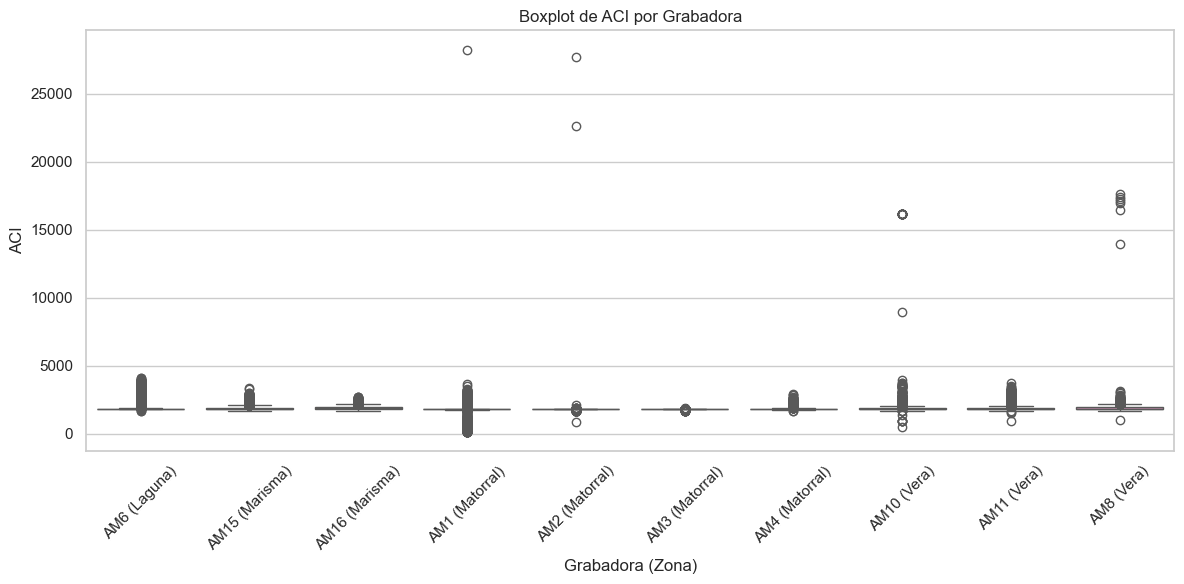

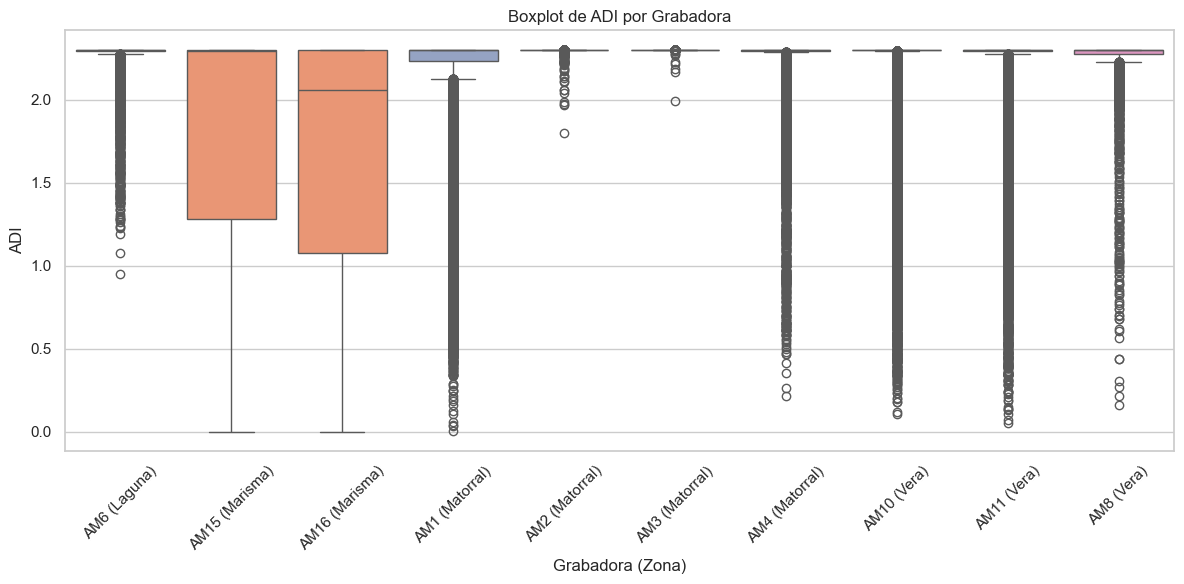

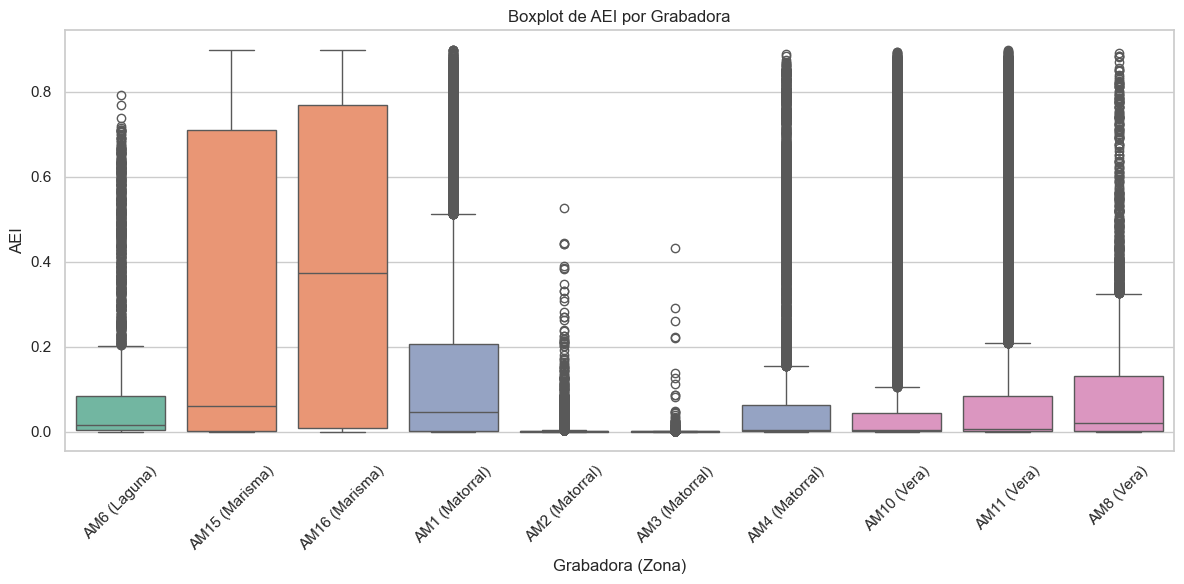

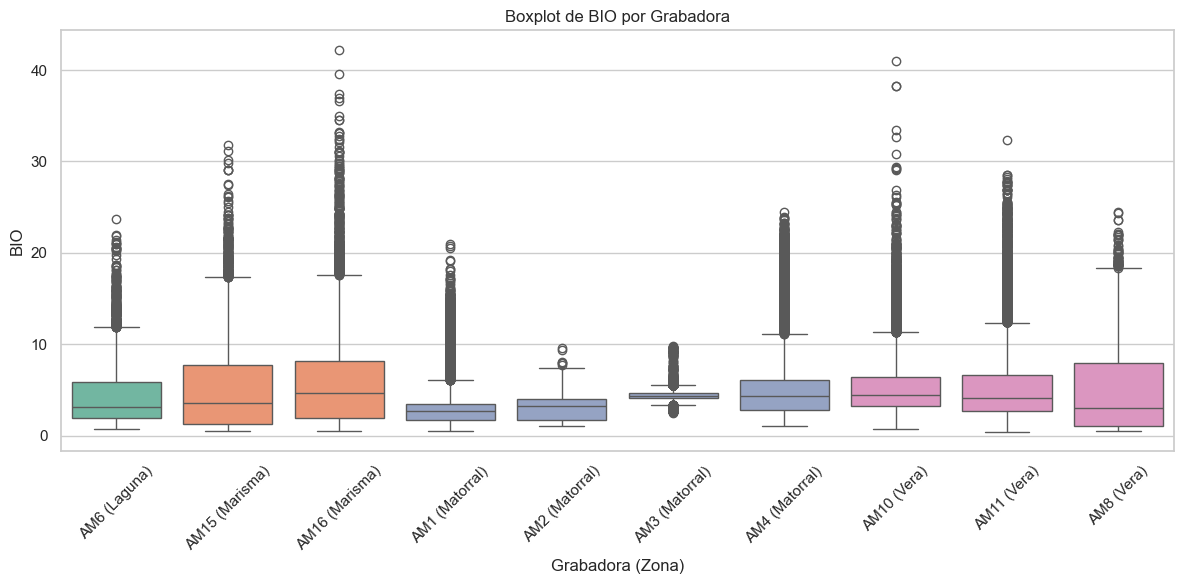

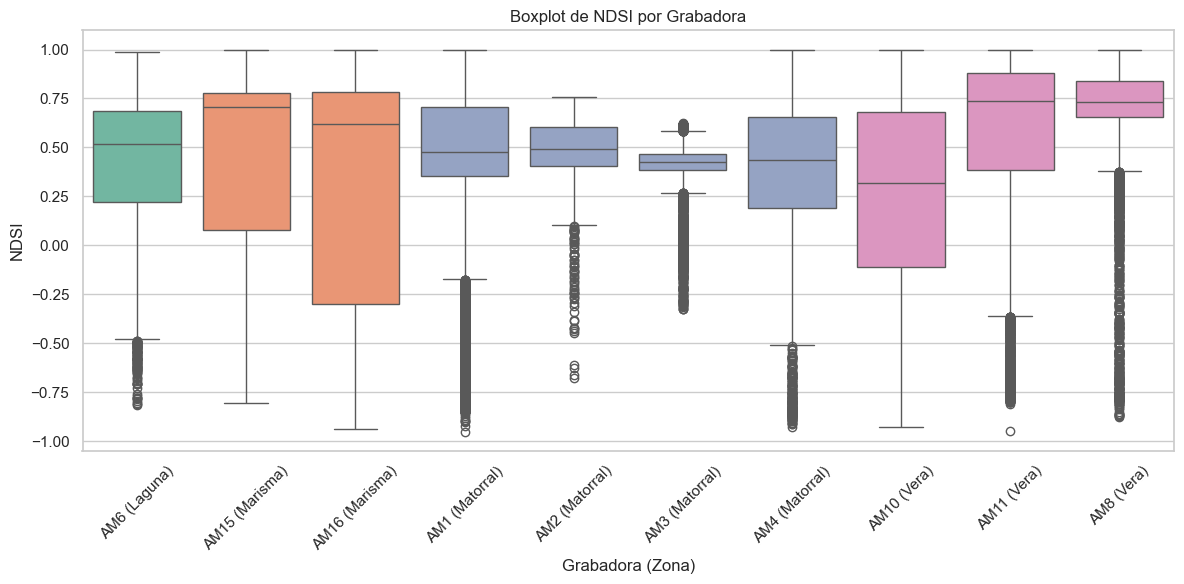

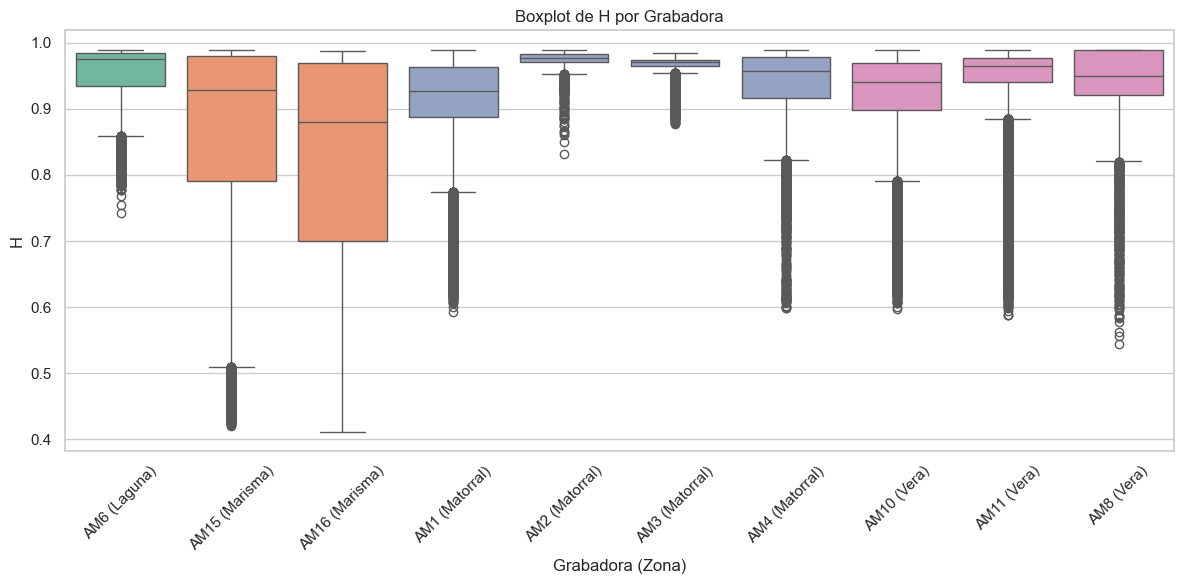

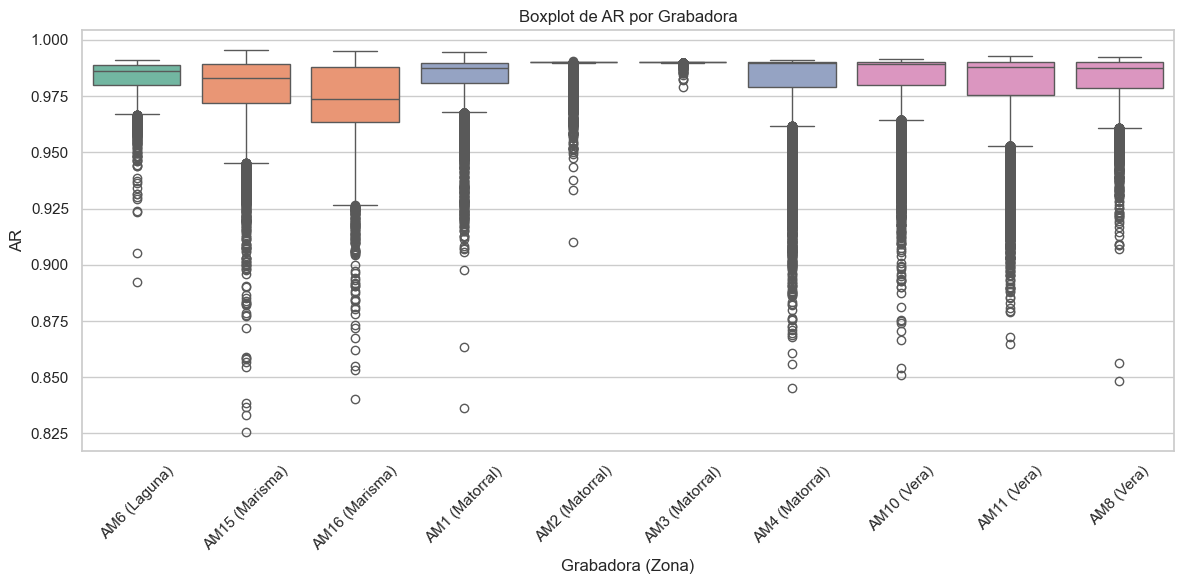

In [7]:
sns.set(style="whitegrid")

# Crear la paleta de colores usando los valores únicos de "zone"
sorted_zones = sorted(df_indices["zone"].unique())
palette = sns.color_palette("Set2", n_colors=len(sorted_zones))
zone_colors = dict(zip(sorted_zones, palette))

# Ordenar las grabadoras por zona (y opcionalmente por nombre)
order = df_indices.sort_values(by=["zone", "recorder_zone"])["recorder_zone"].unique()

for idx in indices:
    plt.figure(figsize=(12, 6))

    # Boxplot: eje x por grabadora, hue por zona, ordenado según "order"
    sns.boxplot(data=df_indices, x="recorder_zone", y=idx, hue="zone",
                order=order, palette=zone_colors, dodge=False)
    plt.title(f"Boxplot de {idx} por Grabadora")
    plt.xlabel("Grabadora (Zona)")
    plt.ylabel(idx)
    plt.xticks(rotation=45)

    # Si no deseas mostrar la leyenda:
    plt.legend([], [], frameon=False)

    plt.tight_layout()
    plt.show()

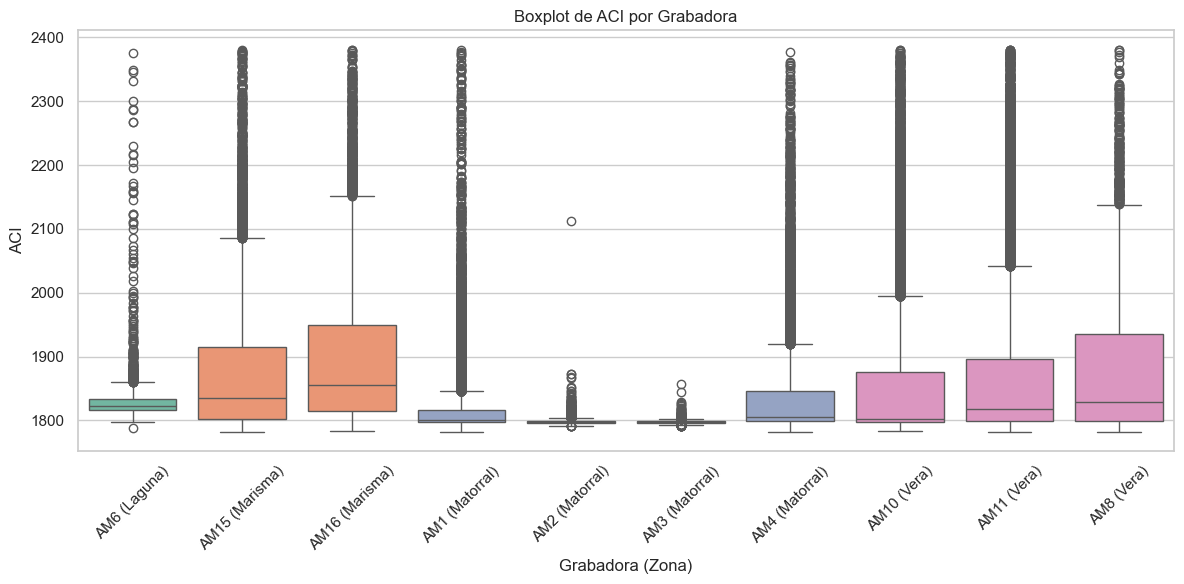

In [8]:
# Filtrar el dataframe para el índice ACI eliminando los valores en el bottom 1% y en el top 1%
q_low = df_indices["ACI"].quantile(0.01)
q_hi = df_indices["ACI"].quantile(0.99)
df_aci = df_indices[(df_indices["ACI"] >= q_low) & (df_indices["ACI"] <= q_hi)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_aci, x="recorder_zone", y="ACI", hue="zone",
            order=order, palette=zone_colors, dodge=False)
plt.title("Boxplot de ACI por Grabadora")
plt.xlabel("Grabadora (Zona)")
plt.ylabel("ACI")
plt.xticks(rotation=45)
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()
